# Comparing BDT and NN Statistics

In [2]:
from __future__ import division
import pickle
import numpy as np
import pandas as pd
import torch as th
from matplotlib import pyplot as plt
from matplotlib import ticker
from torch.autograd import Variable
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score
from nn_classes import *
import utils;

### Load the Data

In [3]:
dilept = np.load("test_sets/ttJets_Dilepton_Bkgd_Tree_test.npy")
semilept1 = np.load("test_sets/ttJets_SingleLeptT_Background_DeepLearningTree_test.npy")
semilept2 = np.load("test_sets/ttJets_SingleLeptFromTbar_Background_DeepLearningTree_test.npy")
ttw = np.load("test_sets/ttW_Background_DeepLearningTree_test.npy")
ttz = np.load("test_sets/ttZ_Background_DeepLearningTree_test.npy")
tth = np.load("test_sets/ttH_hadT_bkgd2_test.npy")

sig1 = np.load("test_sets/ttH_hadT_signal_test.npy")
sig2 = np.load("test_sets/ttJets_SingleLeptFromTbar_Signal_DeepLearningTree_test.npy")
sig3 = np.load("test_sets/ttJets_SingleLeptT_Signal_DeepLearningTree_test.npy")
sig4 = np.load("test_sets/ttW_Signal_DeepLearningTree_test.npy")
sig5 = np.load("test_sets/ttZ_Signal_DeepLearningTree_test.npy")

test = np.load("test_sets/all_testing_basic_set.npy")

bkgd_testset = utils.CollisionDataset(dilept[:, :31])
#bkgd_testset += utils.CollisionDataset(semilept1[:, :31])
#bkgd_testset += utils.CollisionDataset(semilept2[:, :31])
#bkgd_testset += utils.CollisionDataset(ttw[:, :31])
#bkgd_testset += utils.CollisionDataset(ttz[:, :31])
#bkgd_testset += utils.CollisionDataset(tth[:, :31])

#dilept_set = utils.CollisionDataset(dilept[:, :31])
#semileptT_set = utils.CollisionDataset(semilept1[:, :31]) + utils.CollisionDataset(sig3[:, :31])
#semileptTbar_set = utils.CollisionDataset(semilept2[:, :31]) + utils.CollisionDataset(sig2[:, :31])
#tth_set = utils.CollisionDataset(tth[:, :31]) + utils.CollisionDataset(sig1[:, :31])
#ttw_set = utils.CollisionDataset(ttw[:, :31]) + utils.CollisionDataset(sig4[:, :31])
#ttz_set = utils.CollisionDataset(ttz[:, :31]) + utils.CollisionDataset(sig5[:, :31])
#datasets = [dilept_set, semileptT_set, semileptTbar_set, tth_set, ttw_set, ttz_set]
datasets = [utils.CollisionDataset(dilept[:, :31]),
            utils.CollisionDataset(semilept1[:, :31]),
            utils.CollisionDataset(sig3[:, :31]),
            utils.CollisionDataset(semilept2[:, :31]),
            utils.CollisionDataset(sig2[:, :31]),
            utils.CollisionDataset(tth[:, :31]),
            utils.CollisionDataset(sig1[:, :31]),
            utils.CollisionDataset(ttw[:, :31]),
            utils.CollisionDataset(sig4[:, :31]),
            utils.CollisionDataset(ttz[:, :31]),
            utils.CollisionDataset(sig5[:, :31])]
for x in datasets:
    x.load_scaler("all_standardizer.npz")
    x.subsample(5e4)
    
comb_datasets = [utils.CollisionDataset(semilept1[:, :31]) + utils.CollisionDataset(sig3[:, :31]),
                 utils.CollisionDataset(semilept2[:, :31]) + utils.CollisionDataset(sig2[:, :31]),
                 utils.CollisionDataset(tth[:, :31]) + utils.CollisionDataset(sig1[:, :31]),
                 utils.CollisionDataset(ttw[:, :31]) + utils.CollisionDataset(sig4[:, :31]),
                 utils.CollisionDataset(ttz[:, :31]) + utils.CollisionDataset(sig5[:, :31])]
for x in comb_datasets:
    x.load_scaler("all_standardizer.npz")
    x.subsample(5e4)

testset = utils.CollisionDataset(test)

bkgd_testset.load_scaler("all_standardizer.npz")
testset.load_scaler("all_standardizer.npz")
#sig_testset.load_scaler("all_standardizer.npz")

bkgd_testset.subsample(1e5)
#sig_testset.subsample(1e5)
testset.subsample(1e5)

### Load the BDTs

In [22]:
with open("bdt.pkl", 'rb') as f:
    bdt = pickle.load(f)
with open("bdt_eng5.pkl", 'rb') as f:
    bdt5 = pickle.load(f)
with open("basic_bdt.pkl", 'rb') as f: 
    bdt_basic = pickle.load(f)

### Load the Neural Nets

In [21]:
input_dim = bkgd_testset._tX.size()[1]

net = DHTTNet(input_dim).eval()

net.load_state_dict(th.load("all_net.pth"))

## Make Predictions/Discriminants

In [23]:
bdt_predicted = bdt.predict(test_X)
bdt_decision = bdt.decision_function(test_X)

bdt5_predicted = bdt5.predict(test5_X)
bdt5_decision = bdt5.decision_function(test5_X)

bdt_basic_predicted = bdt_basic.predict(raw_test_X)
bdt_basic_decision = bdt_basic.decision_function(raw_test_X)

In [7]:
X, y = sig_testset[:]
X = Variable(X).float()
sig_discriminant = net(X).data
sig_predicted = th.round(sig_discriminant).long()

In [5]:
X, y = bkgd_testset[:]
X = Variable(X).float()
bkgd_discriminant = net(X).data
bkgd_predicted = th.round(bkgd_discriminant).long()

In [6]:
X, y = testset[:]
X = Variable(X).float()
test_discriminant = net(X).data
test_predicted = th.round(test_discriminant).long()

## Generate Summary Statistics
Summary statistics will be calculated using the best cut for each model.
- Precision: The percent of predicted signal that are actually signal (prediction efficiency).
- Recall: The percent of actualy signal that is predicted signal (what percent of signal was identified).

In [8]:
print("\n\nOptimized Deep Neural Net: Basic Features")
print_stats(deep_reg_discriminant, np_raw_nn_testy)



Optimized Deep Neural Net: Basic Features
             precision    recall  f1-score   support

          0       0.86      0.72      0.78    106365
          1       0.76      0.88      0.82    106365

avg / total       0.81      0.80      0.80    212730

Area Under Curve: 0.889614968077


In [24]:
print("BDT: All Features")
print_stats(bdt_decision, test_y)
print("\n\nBDT: 5 Eng Features")
print_stats(bdt5_decision, test5_y)
print("\n\nBDT: Basic Features")
print_stats(bdt_basic_decision, raw_test_y)

BDT: All Features
             precision    recall  f1-score   support

          0       0.85      0.76      0.80     85092
          1       0.78      0.87      0.82     85092

avg / total       0.82      0.81      0.81    170184

Area Under Curve: 0.898582290709


BDT: 5 Eng Features
             precision    recall  f1-score   support

          0       0.83      0.73      0.78     85092
          1       0.76      0.85      0.80     85092

avg / total       0.80      0.79      0.79    170184

Area Under Curve: 0.8769843106


BDT: Basic Features
             precision    recall  f1-score   support

          0       0.76      0.56      0.64     85092
          1       0.65      0.82      0.72     85092

avg / total       0.70      0.69      0.68    170184

Area Under Curve: 0.781664676878


/home/drnevich/miniconda3/envs/ROOT/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Generate ROC Curves

In [24]:
def overlay_roc_curves(experiments, title=""):
    fig, ax = plt.subplots()
    for exp in experiments:
        roc_points = roc_curve(exp['targets'], exp['discriminant'])
        plt.plot(roc_points[0], roc_points[1], label=exp.get("label"))
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_title("ROC Curves {}".format(title))
    plt.legend(loc='lower right')
    fig.set_size_inches(18, 10)

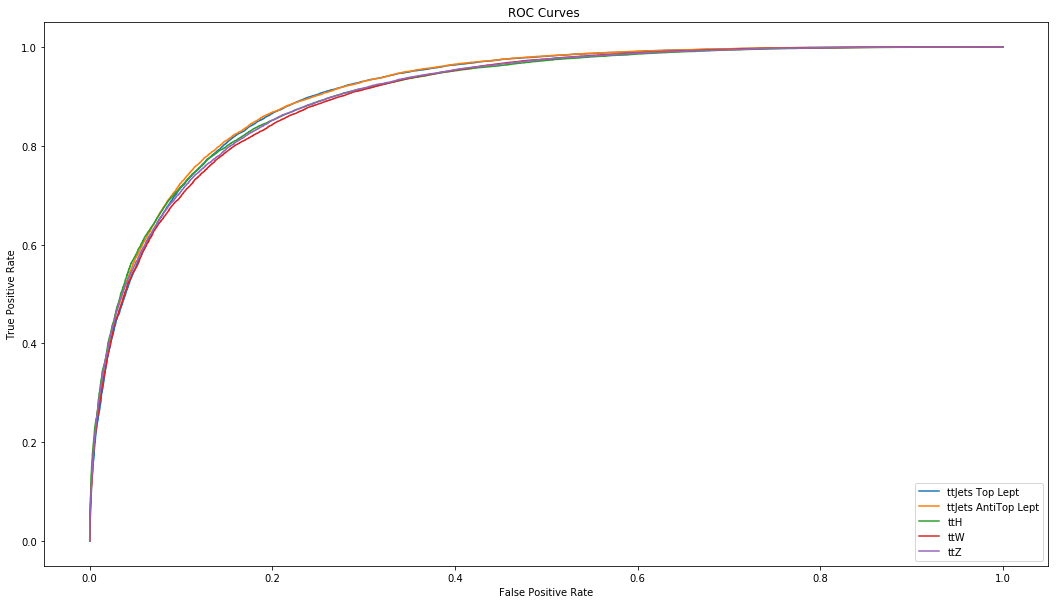

In [25]:
overlay_roc_curves([{'discriminant': x[0],
                    'targets': x[1],
                    'label': x[2]} for x in zip(comb_discriminants, comb_y, comb_labels)])

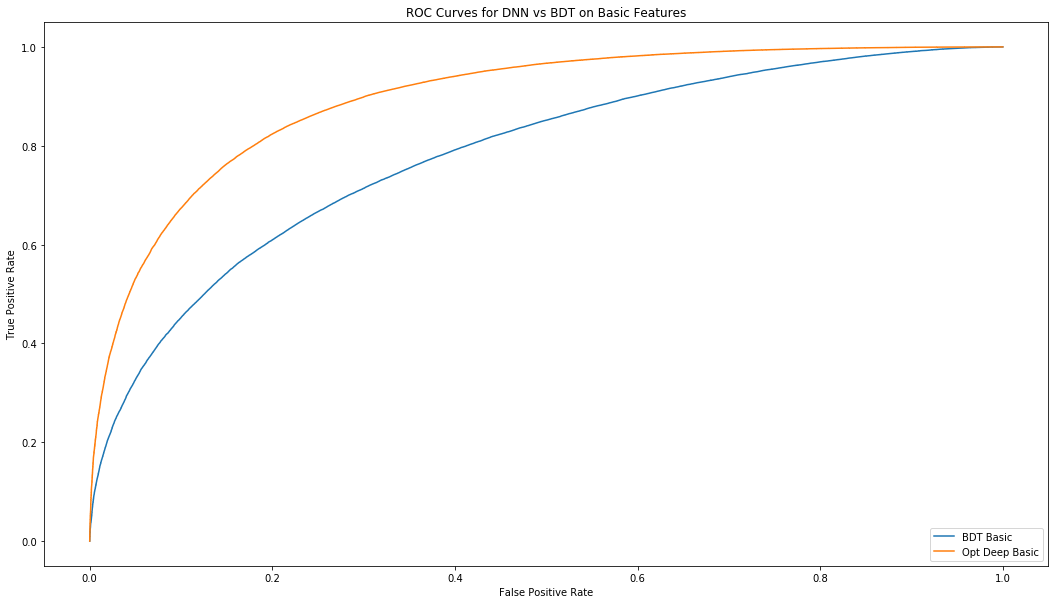

In [26]:
overlay_roc_curves([{'discriminant': bdt_basic_decision,
                    'targets': raw_test_y,
                    'label': "BDT Basic"},
                    {'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="DNN vs BDT on Basic Features")

## Plot Distributions

In [9]:
def plot_distro(experiments, title="NN"):
    fig, ax = plt.subplots()
    for exp in experiments:
        dsignal, dbkgd = exp['discriminant'][(exp['targets'] == 1)], exp['discriminant'][(exp['targets'] == 0)]
    plt.hist(dsignal, alpha=0.5, label="Signal")
    plt.hist(dbkgd, alpha=0.5, label="Background")
    ax.set_ylabel("Count")
    ax.set_xlabel("Output")
    ax.set_title("Output Distribution for {}".format(title))
    plt.legend(loc='lower right')
    fig.set_size_inches(18, 10)

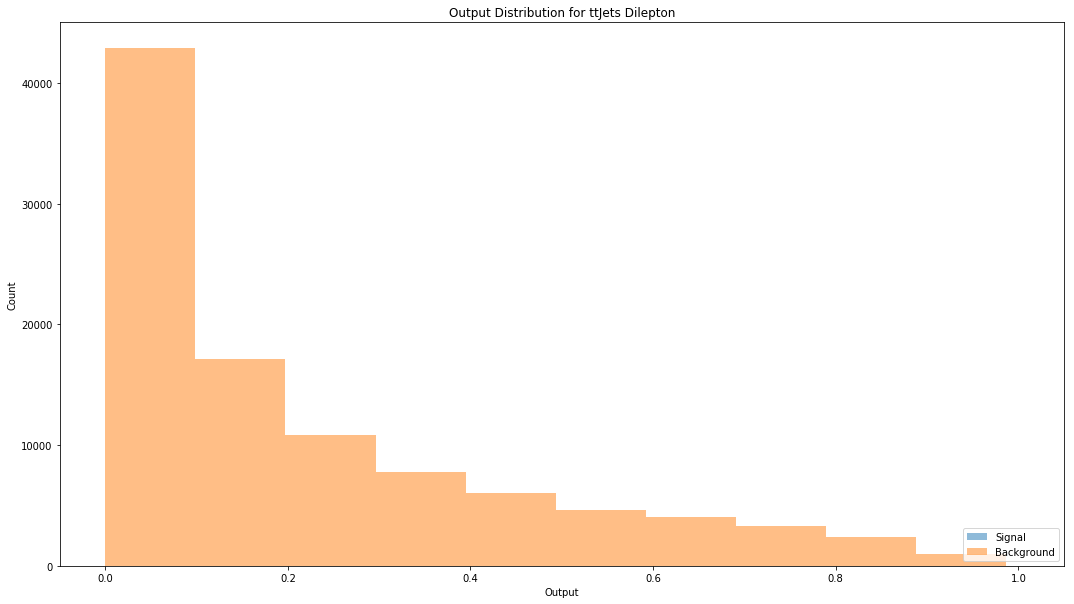

In [10]:
plot_distro([{'discriminant': bkgd_discriminant.numpy(),
                    'targets': bkgd_testset[:][1].numpy(),
                    'label': "All"}], title="ttJets Dilepton")

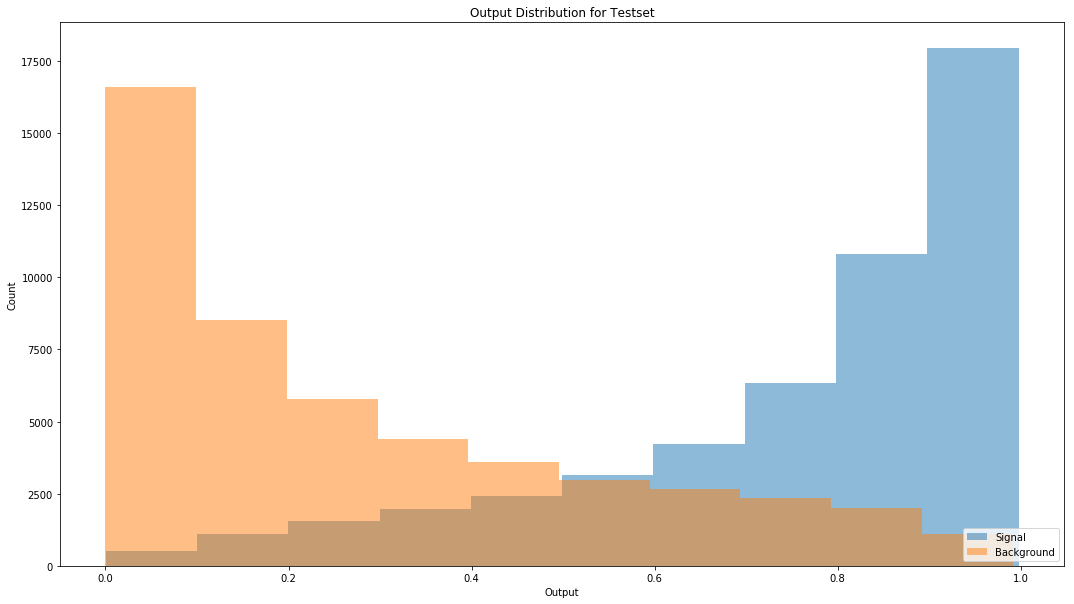

In [11]:
plot_distro([{'discriminant': test_discriminant.numpy(),
                    'targets': testset[:][1].numpy(),
                    'label': "All"}], title="Testset")

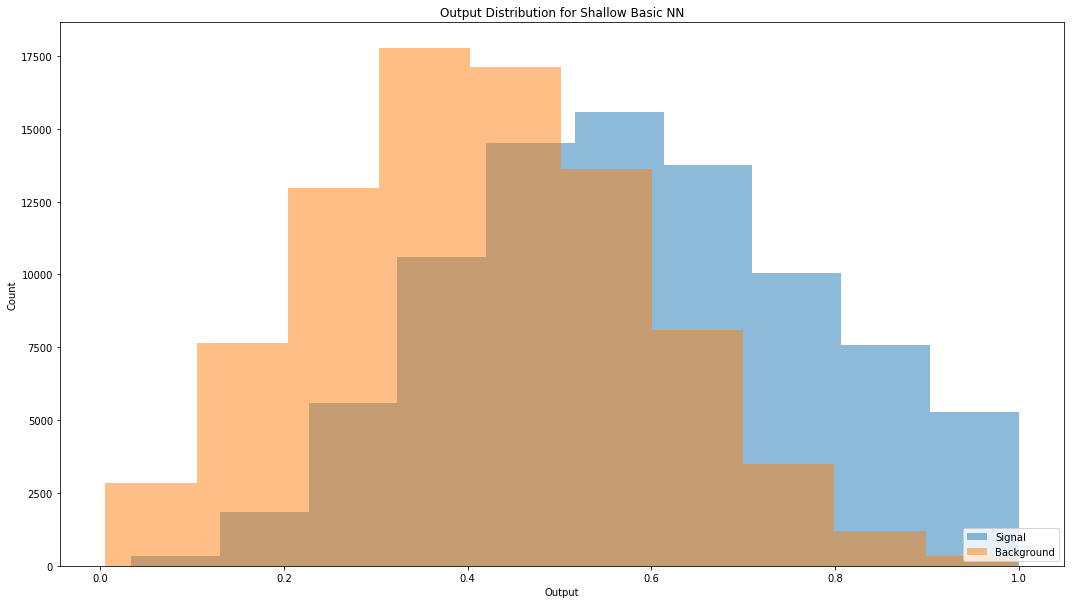

In [13]:
plot_distro([{'discriminant': raw_discriminant,
              'targets': raw_nn_testy.data.numpy(),
              'label': "Basic"}], title="Shallow Basic NN")

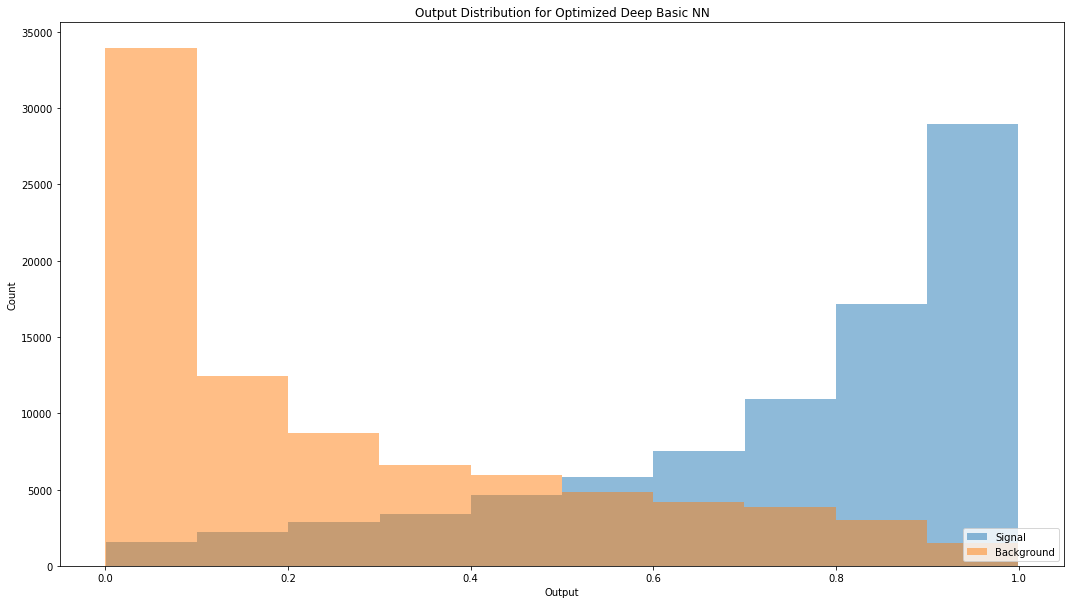

In [16]:
plot_distro([{'discriminant': deep_reg_discriminant,
                     'targets': np_raw_nn_testy,
                     'label': "Opt Deep Basic"}], title="Optimized Deep Basic NN")

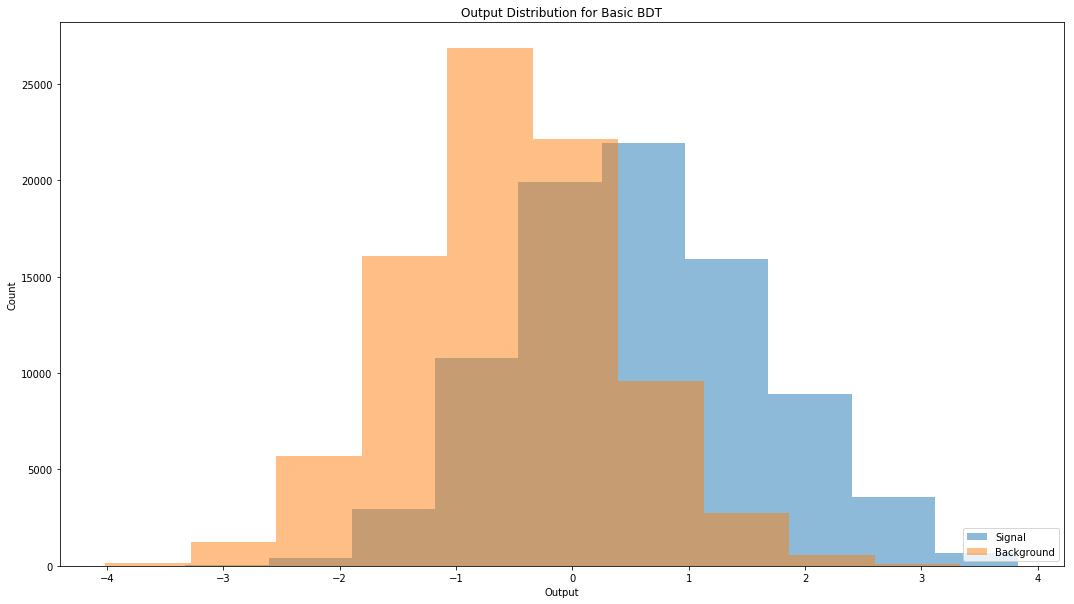

In [27]:
plot_distro([{'discriminant': bdt_basic_decision,
                     'targets': raw_test_y,
                     'label': "Basic BDT"}], title="Basic BDT")

In [12]:
cut = utils.find_cut(net, testset)

In [13]:
utils.score(net, testset, cut=cut)

0.81213

In [14]:
cut

0.46894322186682075

In [15]:
def multiclass_confusion(data, cut=0.5):
    # Assumes list of Torch or numpy tensors in pairs (discriminant, label)
    matrix = []
    labels = []
    for d in data:
        total = len(d[0])
        sig = (d[0] >= cut).sum()
        matrix.append([(total - sig)/total, sig/total])   
        labels.append(d[1])
        
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(matrix, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
    ax.set_yticks(np.arange(len(data))+0.5, minor=False)
    ax.set_xticks(np.arange(2)+0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_yticklabels(labels, minor=False)
    ax.set_xticklabels(["Background", "Signal"], minor=False)
    cb = plt.colorbar(heatmap)
    tick_locator = ticker.MaxNLocator(nbins=10)
    cb.locator = tick_locator
    cb.update_ticks()
    fig.set_size_inches(5, 10)
    
def multiclass_stats(data, cut=0.5):
    # Assumes list of Torch tensors in pairs (discriminant, y, label)
    matrix = []
    labels = []
    for d in data:
        pred = (d[0] >= cut).numpy()
        matrix.append([precision_score(d[1], pred, pos_label=0),
                       recall_score(d[1], pred, pos_label=0),
                       precision_score(d[1], pred),
                       recall_score(d[1], pred)])   
        labels.append(d[2])
        
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(matrix, cmap=plt.cm.coolwarm, vmin=0, vmax=1)
    ax.set_yticks(np.arange(len(data))+0.5, minor=False)
    ax.set_xticks(np.arange(4)+0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_yticklabels(labels, minor=False)
    ax.set_xticklabels(["0 - Precision", "0 - Recall", "1 - Precision", "1 - Recall"], minor=False)
    cb = plt.colorbar(heatmap)
    tick_locator = ticker.MaxNLocator(nbins=20)
    cb.locator = tick_locator
    cb.update_ticks()
    fig.set_size_inches(10, 10)

In [16]:
labels = ["ttJets Dilepton", "ttJets Top Lept: Bkgd", "ttJets Top Lept: Sig",
          "ttJets AntiTop Lept: Bkgd", "ttJets AntiTop Lept: Sig",
          "ttH: Bkgd", "ttH: Sig",
          "ttW: Bkgd", "ttW: Sig", 
          "ttZ: Bkgd", "ttZ: Sig"]
discriminants = [net(Variable(dset[:][0]).float()).data for dset in datasets]

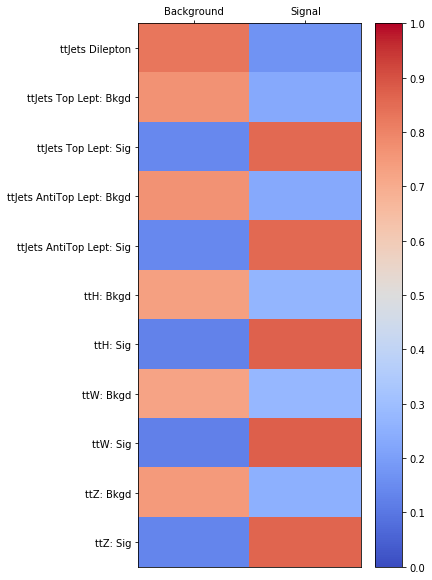

In [17]:
multiclass_confusion(zip(discriminants, labels), cut=cut)

In [22]:
comb_labels = ["ttJets Top Lept", "ttJets AntiTop Lept", "ttH", "ttW", "ttZ"]
comb_y = [dset[:][1] for dset in comb_datasets]
comb_discriminants = [net(Variable(dset[:][0]).float()).data for dset in comb_datasets]

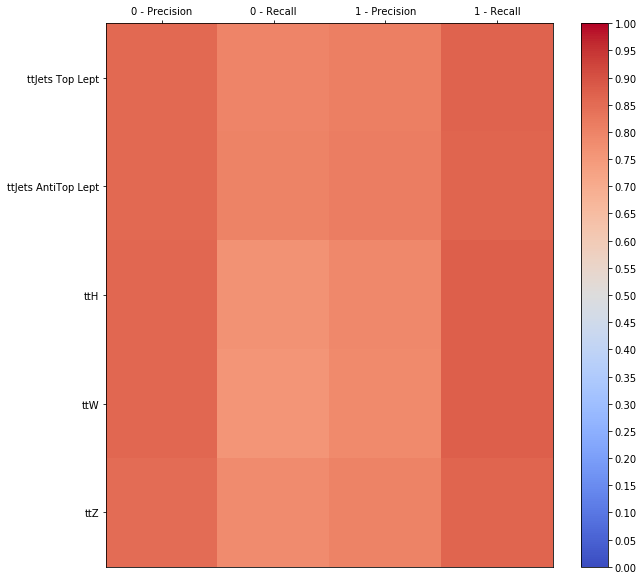

In [23]:
multiclass_stats(zip(comb_discriminants, comb_y, comb_labels), cut=cut)